#Visita [andreabaraldi.it/covid](https://andreabaraldi.it/covid) per visualizzare la nuova versione!

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


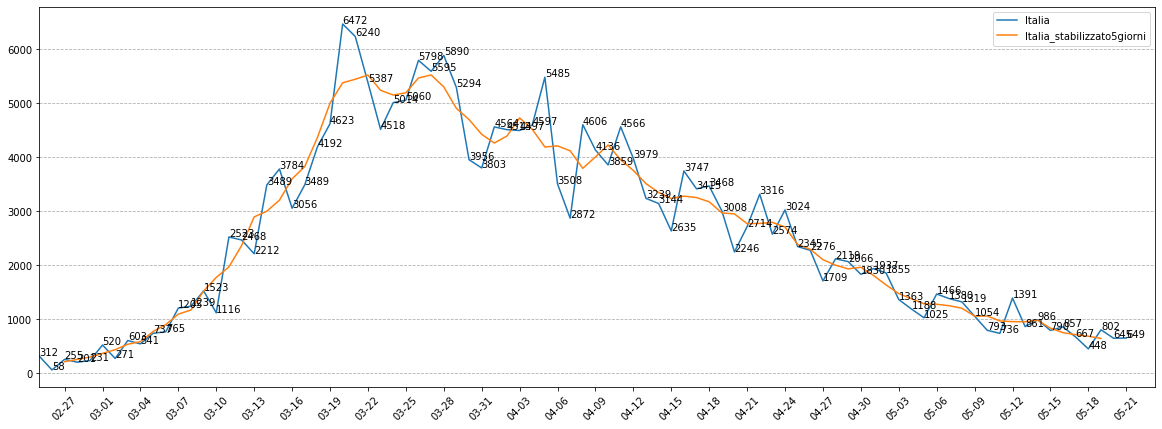

In [26]:
import os
covid_path = os.path.join(os.path.abspath('.'), 'drive', 'My Drive', 'IT', 'Python', 'covid', 'plots')
#@ title Cresciata giornaliera di contagi sull\'intero territorio Italiano

import requests
import pandas as pd
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')

rilevazioni = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
rilevazioni['data'] = rilevazioni['data'].apply(lambda x : x[5:10])
rilevazioni = rilevazioni.drop(rilevazioni[rilevazioni['denominazione_provincia'] == 'In fase di definizione/aggiornamento'].index)
rilevazioni = rilevazioni.pivot_table(index=['denominazione_regione','denominazione_provincia'], columns='data', values='totale_casi')
rilevazioni.index.names = ['Regione', 'Provincia']


def avg_serie(dataset, day=5, add_name=True):
  avg_df = pd.DataFrame(index=dataset.index.copy())

  for pos in range(day-1, len(dataset.columns)):
    avg_df[dataset.columns[pos - round(day/2)]] = dataset.iloc[:,pos-day+1:pos+1].mean(axis=1)
  avg_df = avg_df.astype('int32')
  if add_name:
    if not hasattr(avg_df.index, 'levels'):
      avg_df.set_index(avg_df.index+'_stabilizzato'+str(day)+'giorni', inplace=True)
    else:
      avg_df.index.set_levels(avg_df.index.levels[1]+'_stabilizzato'+str(day)+'giorni',level=1, inplace=True)
  return avg_df

import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7), avg=False, annotation=True, path=None):
  if avg!=False:
    tmp = pd.concat([df,avg_serie(df,avg)])
  else:
    tmp = df
  ax = tmp.T.plot(figsize=figsize, title=title)
  step_size = max(round(len(df.columns) / 25 - 0.5),1)
  resto = (len(df.columns)-1) % step_size
  ax.set_xticks(ticks=np.arange(resto, len(df.columns) , step=step_size))
  tick_label = list(df.columns)[resto::step_size]
  ax.set_xticklabels(tick_label, rotation=45)
  ax.grid(axis='y', linestyle='--')
  ax.set_xlim(left=0, right=ax.get_xlim()[1]-2)

  #ax.yaxis.tick_right()
  if annotation == True:
    count = 0
    for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
      #if count % 2 == 0:
      for el in v[1]:
        ax.annotate(el, (k + xdelta, el + ydelta))
      count +=1
  if path != None:
    plt.savefig(path)
  return ax


sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]
crescita = pd.DataFrame(index=sorted_by_infections.index)
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]

crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']


_ = plot_annotate(crescita_italia, avg=5,path=covid_path+'/Italia.jpg', figsize=(20,7))

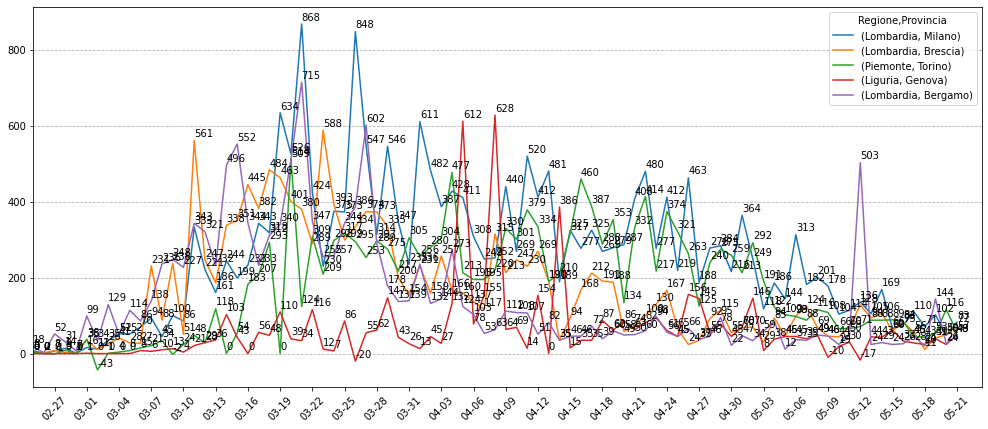

In [27]:
#@ title Crescita giornaliere di contagi per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5),path=covid_path+'/Provincie-01.jpg')
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

In [28]:
xx = crescita.sort_values(by=crescita.columns[-1], ascending=False).iloc[:13,-5:].T
with open(covid_path+'/frame01.html', 'w') as out:
  out.write(xx.to_html())
xx

Regione   Lombardia         Piemonte  ... Lombardia Lazio Piemonte
Provincia    Milano Brescia   Torino  ...   Cremona  Roma   Novara
05-17           110      56       45  ...        10    39        4
05-18            71      11       43  ...         0    30        5
05-19           102      41       53  ...        12     8       38
05-20            48      50      116  ...        15    20       15
05-21            83      77       57  ...        15    15       13

[5 rows x 13 columns]

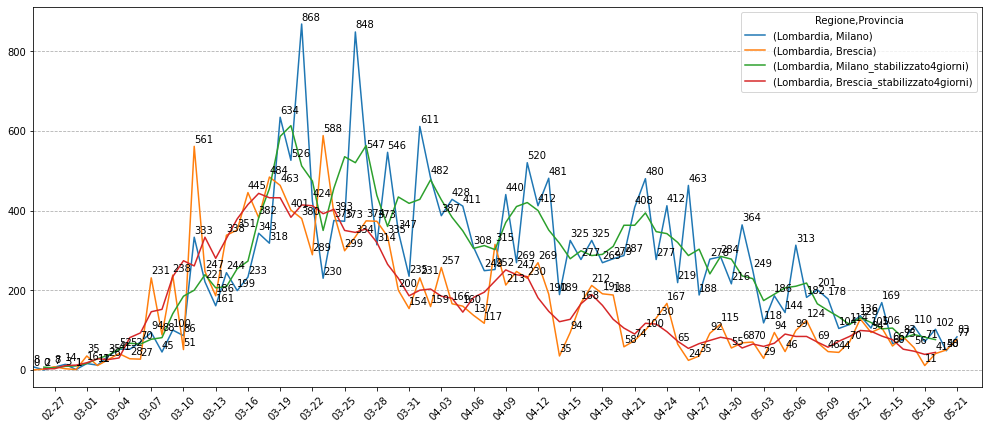

In [29]:
#@ title Crescita giornaliera di contagi mediata su un intervallo di 4 giorni per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(2), avg=4, path=covid_path+'/Provincie-02.jpg')
#_ = plot_annotate(avg_serie(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5), day=4))

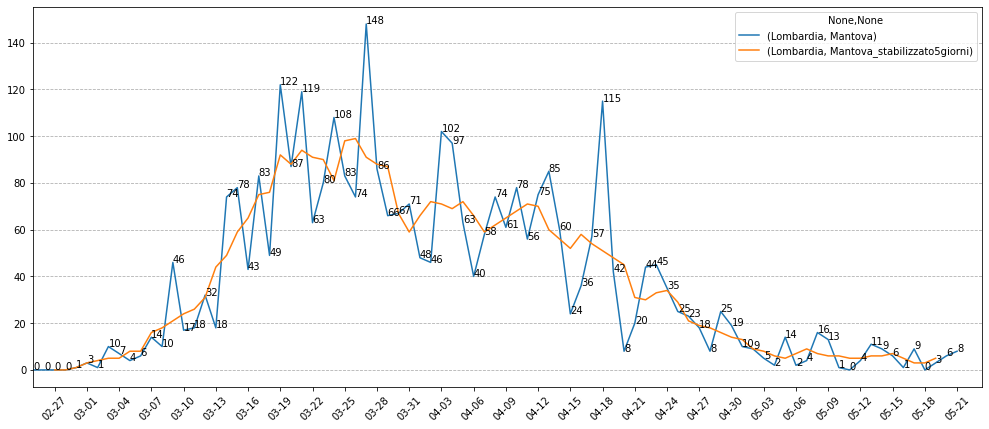

In [30]:
#@ title Crescita giornaliera di contagi a Mantova
_ = plot_annotate(crescita.loc[('Lombardia','Mantova')].to_frame().T, ydelta=0, avg=5, path=covid_path+'/Mantova.jpg')

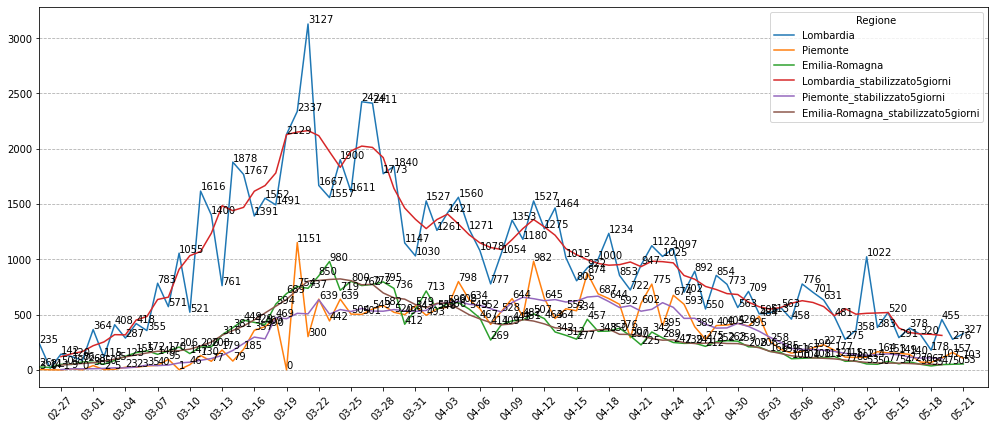

In [31]:
#@ title Crescita giornaliera per le regioni maggiormente infette
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(3), avg=5, path=covid_path+'/Regioni.jpg')


In [32]:
xx = crescita_regioni.iloc[:10,-5:].T
with open(covid_path+'/frame02.html', 'w') as out:
  out.write(xx.to_html())
xx

Regione,Lombardia,Piemonte,Emilia-Romagna,Veneto,Toscana,Liguria,Lazio,Marche,Campania,Puglia
05-17,320,70,50,15,35,48,49,24,8,5
05-18,178,67,35,11,13,32,38,11,9,7
05-19,455,107,47,46,7,66,20,-4,12,9
05-20,276,157,50,33,14,32,28,2,5,12
05-21,327,103,53,8,18,55,24,11,8,6


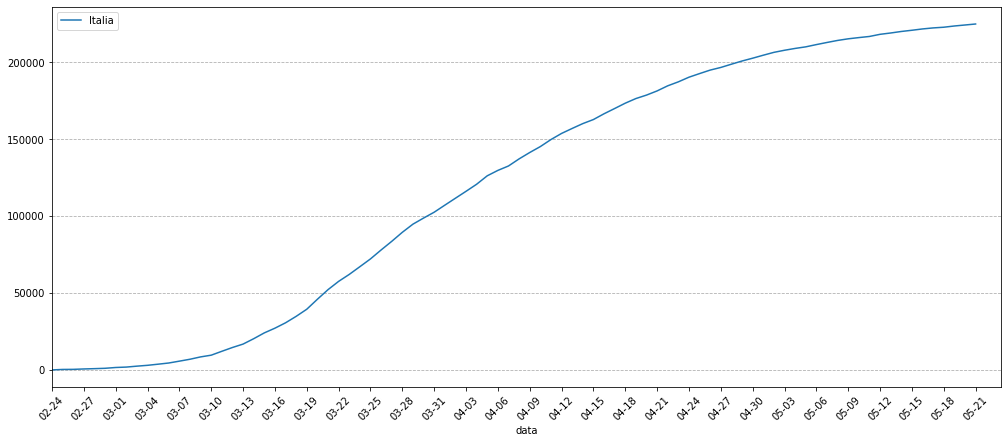

In [33]:
#@ title Contagi totali in Italia
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']
_ = plot_annotate(casi_italia, xdelta=0.5, annotation=False, path=covid_path+'/Totale Italia.jpg')

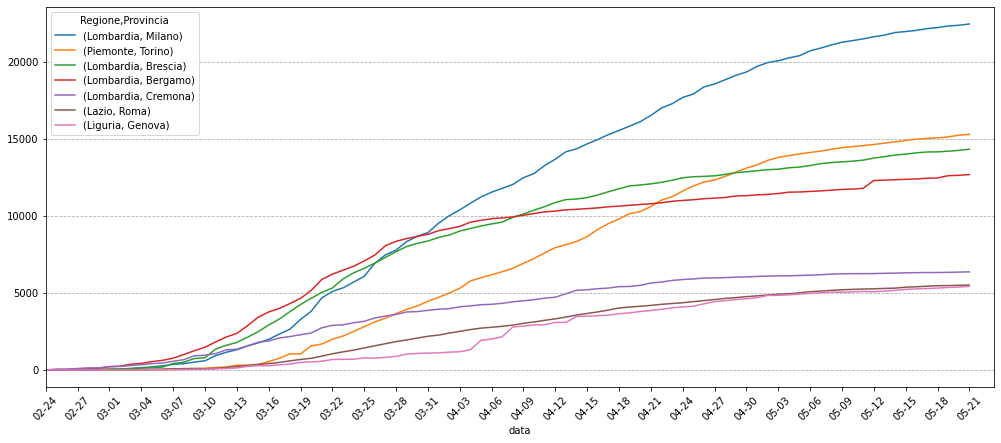

In [34]:
#@ title Contagi totali per le province maggiormente infette
_ = plot_annotate(sorted_by_infections.head(7), annotation=False, path=covid_path+'/Totale Provincie.jpg')

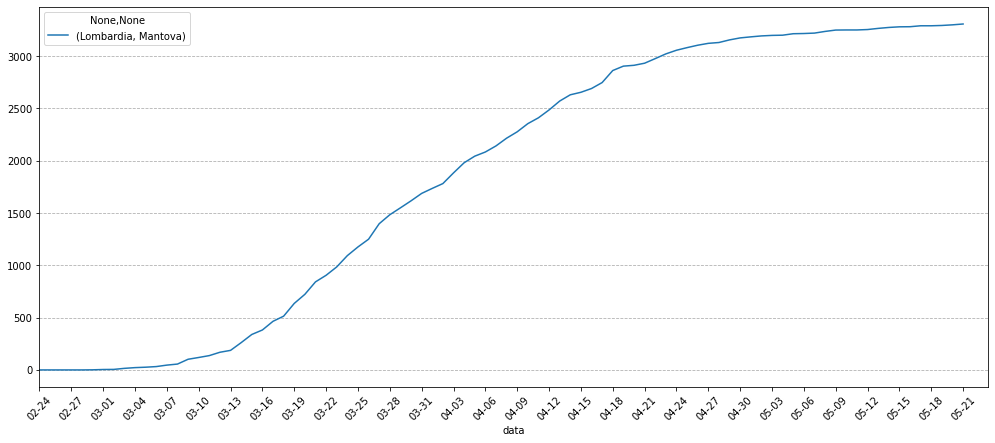

In [35]:
#@ title Contagi totali a Mantova
_ = plot_annotate(sorted_by_infections.loc[('Lombardia','Mantova')].to_frame().T, annotation=False, path=covid_path+'/Totale Mantova.jpg')

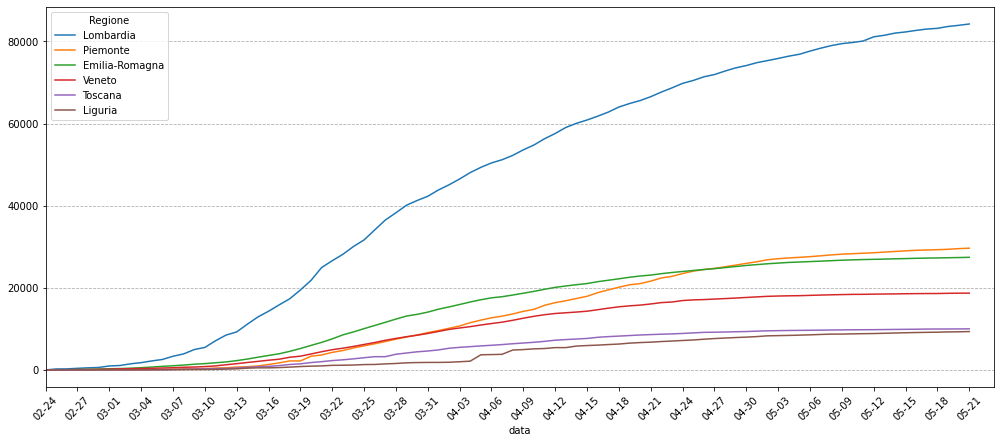

In [36]:
#@ title Contagi totali regioni
_ = plot_annotate(regioni.head(6), annotation=False, path=covid_path+'/Totale regioni.jpg')